In [1]:
import pandas as pd
import numpy as np
import functools
#from tensorflow import keras
#from tensorflow.keras import utils
from sklearn import tree, model_selection
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
import gc
#import pickle
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree, export_text

In [2]:
data = pd.read_excel(r'/home/sudarsun/notebooks/Sudar_sir_claims_scrubber_data_historical_v1.xlsx')

In [3]:
data.columns

Index(['claim_id', 'patient_id', 'payer_id', 'plan_name', 'denial_code',
       'code_activity', 'activity_desc', 'type_activity', 'act_type_dsc',
       'pdx', 'sdx', 'Reason_for_visit', 'consolidated_diagnoses'],
      dtype='object')

In [4]:
nrecords = len(data)

In [5]:
# handle NAs in the denial code outputs
data["denial_code"] = data["denial_code"].fillna("PASS")
dc_distrib = data["denial_code"].value_counts()
print(dc_distrib)

PASS         478574
MNEC-004     102590
PRCE-002       7419
PRCE-001       7305
CODE-010       4061
MNEC-005       3894
CLAI-012       1827
NCOV-0026      1518
DUPL-002       1413
PRCE-006        609
COPY-001        400
NCOV-001        337
AUTH-001        308
PRCE-010        286
CODE-014        245
ELIG-006        216
NCOV-003        213
ELIG-001        210
PRCE-007        186
TIME-001        178
CLAI-008        117
ELIG-007        116
AUTH-003        105
CLAI-016         62
BENX-002         59
BENX-005         57
AUTH-005         50
ELIG-005         43
MNEC-003         42
AUTH-004         29
DUPL-001          2
CLAI-018          1
Name: denial_code, dtype: int64


In [6]:
denial_codes = pd.unique(data["denial_code"])
print("labels found", denial_codes)

labels found ['PASS' 'MNEC-004' 'PRCE-010' 'PRCE-002' 'CLAI-012' 'MNEC-005' 'CODE-010'
 'DUPL-002' 'PRCE-001' 'PRCE-006' 'CODE-014' 'AUTH-001' 'AUTH-003'
 'CLAI-016' 'PRCE-007' 'NCOV-003' 'NCOV-001' 'AUTH-005' 'ELIG-005'
 'ELIG-001' 'ELIG-007' 'ELIG-006' 'CLAI-008' 'MNEC-003' 'AUTH-004'
 'NCOV-0026' 'TIME-001' 'BENX-002' 'COPY-001' 'BENX-005' 'CLAI-018'
 'DUPL-001']


In [7]:
# set the classes of interest.
#denial_codes = list(dc_distrib.keys())
denial_codes = ["PASS", "MNEC-004"]
print('class labels of interest', denial_codes)

class labels of interest ['PASS', 'MNEC-004']


In [8]:
# we are strongly assuming that the data is not multi-label.
# get the unique cpt codes
cpt = pd.unique(list(data["code_activity"]))
print("unique CPT codes ->", cpt)
print("# unique CPTs: ", len(cpt))

unique CPT codes -> [76700 99283 'I88-4273-03444-01' ... 82384 'C15-1794-00146-01' 73706]
# unique CPTs:  1574


In [9]:
#clear previously owned
if "pdx_icds" in locals():
    # release the memory blocks
    del(pdx_icds)
    del(sdx_icds)
    del(rov_icds)
    gc.collect()
    
# collect the icd codes from the diagnosis columns
pdx_icds = [str(code).split(',') for code in data[data["pdx"].notna()]["pdx"]]
sdx_icds = [str(code).split(',') for code in data[data["sdx"].notna()]["sdx"]] 
rov_icds = [str(code).split(',') for code in data[data["Reason_for_visit"].notna()]["Reason_for_visit"]]

In [10]:
# collect the pdx items
pdx = []
for row in pdx_icds:
    for code in row:
        pdx.append(code)
# collect the sdx items
sdx = []
for row in sdx_icds:
    for code in row:
        sdx.append(code)
# collect the rov items        
rov = []
for row in rov_icds:
    for code in row:
        rov.append(code)

In [11]:
# get the unique ICD codes.
icd = pd.unique(pdx + sdx + rov)
print("unique icd codes ->", icd)
print("# unique icds: ", len(icd))

unique icd codes -> ['R10.84' 'K76.0' 'M25.562' ... 'S80.811D' 'K25.3' 'T24.012A']
# unique icds:  7388


In [12]:
# forward and reverse index the unique codes.
icd_indices = dict((i,c) for c,i in enumerate(icd))
cpt_indices = dict((str(c),i) for i, c in enumerate(cpt))
denial_indices = dict((str(c),i) for i, c in enumerate(denial_codes))

In [13]:
print(denial_indices)
print(denial_codes)

{'PASS': 0, 'MNEC-004': 1}
['PASS', 'MNEC-004']


In [14]:
# construct a new data frame with only the necessary data.
dc_array = denial_codes.copy()
new_data = data[data["denial_code"] == dc_array[0]]
dc_array.pop(0)
for dc in dc_array:
    mydf = data[data["denial_code"] == dc]
    new_data = new_data.append(mydf)
new_data["denial_code"].value_counts()

# update the no of records.
nrecords = len(new_data)

# @TODO we should destroy the original data frame for memory saving.

In [15]:
def encode_column(coldata, index):
    encoded = []
    for r in coldata:
        # check for nan by doing this comparison.
        if r != r:
            encoded.append([])
        else:
            codes = list(map(lambda x: index[x], str(r).split(",")))
            encoded.append(codes)
    return encoded

In [16]:
# encode the claim result
#claim_status = new_data["denial_code"] == "PASS"
#let's first compute the class prior
#prior = claim_status.value_counts(normalize=True)

prior = new_data["denial_code"].value_counts(dropna=False, normalize=True)
print(prior)

PASS        0.823475
MNEC-004    0.176525
Name: denial_code, dtype: float64


In [17]:
# let's split the train and test datasets from the input.
proportion = 0.6
train_size = int(nrecords * proportion)

# generate a random permutation of the indicces
p_index = np.random.permutation(nrecords)

# identify the items for training and hold out.
tr_index = dict((k,i) for (i,k) in enumerate(p_index[0:train_size]))
te_index = dict((k,i) for (i,k) in enumerate(p_index[train_size:]))


In [18]:
def uniform_prior(prior):
    result = prior.copy()
    spread = 1./len(prior)
    for k in prior.keys():
        result[k] = spread
    return result

In [66]:
# set the required testing data prior
test_prior = prior
#test_prior = uniform_prior(prior)
print("\nRequired test prior:\n",test_prior)

# override the train prior if needed
#train_prior = prior
train_prior = uniform_prior(prior)
print("\nRequired train prior:\n", train_prior)


Required test prior:
 PASS        0.823475
MNEC-004    0.176525
Name: denial_code, dtype: float64

Required train prior:
 PASS        0.5
MNEC-004    0.5
Name: denial_code, dtype: float64


In [69]:
# set the number of required training & testing sample sizes
ntrain = 200000
ntest = 100000

In [70]:
# now collect the ids for training and testing samples.
train_ids = []    
test_ids = []

cum_train = 0
cum_test = 0
# now, we have to draw the sample from tr_indexed data points, hopefully following the class prior.
for c in prior.keys():
    # get the required training data count
    req_ntrain = int(train_prior[c] * ntrain)
    req_ntest = int(test_prior[c] * ntest)
    
    # get the keys from the data
    #keys = data[data["denial_code"]==c]["denial_code"].keys()
    keys = new_data[new_data["denial_code"]==c]["denial_code"].keys()
    print(c, "--> available points:", len(keys), "required train points,", req_ntrain, "test points:", req_ntest)
    for k in keys:
        if k in tr_index and len(train_ids)-cum_train < req_ntrain:
            train_ids.append(k)
        if k in te_index and len(test_ids)-cum_test < req_ntest:
            test_ids.append(k)
    print("got", len(train_ids)-cum_train, "train &", len(test_ids)-cum_test, "test points.")
    cum_train = len(train_ids)
    cum_test = len(test_ids)

print("\nRequired train data prior:\n", train_prior)
print("\nActual train data prior:\n", new_data["denial_code"][train_ids].value_counts(normalize=True))
print("\nRequired test data prior:\n", test_prior)
print("\nActual test data prior:\n", new_data["denial_code"][test_ids].value_counts(normalize=True))

PASS --> available points: 478574 required train points, 100000 test points: 82347
got 100000 train & 82347 test points.
MNEC-004 --> available points: 102590 required train points, 100000 test points: 17652
got 59154 train & 17652 test points.

Required train data prior:
 PASS        0.5
MNEC-004    0.5
Name: denial_code, dtype: float64

Actual train data prior:
 PASS        0.628322
MNEC-004    0.371678
Name: denial_code, dtype: float64

Required test data prior:
 PASS        0.823475
MNEC-004    0.176525
Name: denial_code, dtype: float64

Actual test data prior:
 PASS        0.823478
MNEC-004    0.176522
Name: denial_code, dtype: float64


In [71]:
#encode the PDX column
pdx_encoded_tr = encode_column(new_data["pdx"][train_ids], icd_indices)
pdx_encoded_te = encode_column(new_data["pdx"][test_ids], icd_indices)

In [72]:
#encode the SDX column
sdx_encoded_tr = encode_column(new_data["sdx"][train_ids], icd_indices)
sdx_encoded_te = encode_column(new_data["sdx"][test_ids], icd_indices)

In [73]:
# encode the ROV column
rov_encoded_tr = encode_column(new_data["Reason_for_visit"][train_ids], icd_indices)
rov_encoded_te = encode_column(new_data["Reason_for_visit"][test_ids], icd_indices)

In [74]:
# encode the CPT column
cpt_encoded_tr = encode_column(new_data["code_activity"][train_ids], cpt_indices)
cpt_encoded_te = encode_column(new_data["code_activity"][test_ids], cpt_indices)

In [75]:
def transform_denial_code(c, denial_index):
    if c != c:
        return 0
    return denial_index[c]

In [76]:
# encode the denial column
denial_encoded_tr = list(map(lambda x: transform_denial_code(x, denial_indices), new_data["denial_code"][train_ids]))
denial_encoded_te = list(map(lambda x: transform_denial_code(x, denial_indices), new_data["denial_code"][test_ids]))

In [77]:
# get the output column ready
#y_train = list(claim_status[train_ids])
#y_test = list(claim_status[test_ids])

In [78]:
def one_hot(record, num_classes):
    encoded = np.zeros(num_classes)
    for r in record:
        encoded[r] = 1.
    return encoded

In [79]:
#def one_hot_encode(index, multilabel):
#    encoded = np.zeros(len(index))
#    for label in multilabel:
#        print(label)
#        if label in index:
#            print(index[label])
#            encoded[index[label]] = 1.
#    return encoded

In [80]:
# free up the space explicitly
if 'X_train' in locals():
    del(X_train) 
    del(X_test)
    gc.collect()

X_train = [np.hstack((one_hot(cpt_encoded_tr[i], num_classes=len(cpt_indices)), 
                      one_hot(rov_encoded_tr[i], num_classes=len(icd_indices)),
                      one_hot(sdx_encoded_tr[i], num_classes=len(icd_indices)),
                      one_hot(pdx_encoded_tr[i], num_classes=len(icd_indices)))) for i in range(len(train_ids))]
X_test  = [np.hstack((one_hot(cpt_encoded_te[i], num_classes=len(cpt_indices)), 
                      one_hot(rov_encoded_te[i], num_classes=len(icd_indices)),
                      one_hot(sdx_encoded_te[i], num_classes=len(icd_indices)),
                      one_hot(pdx_encoded_te[i], num_classes=len(icd_indices)))) for i in range(len(test_ids))]

In [81]:
# free up the space explicitly
if 'features' in locals():
    del(features)
    gc.collect()

features = list(cpt_indices.keys()) + ["RFV-"+k for k in icd_indices.keys()] + ["SDX-"+k for k in icd_indices.keys()] + ["PDX-"+k for k in icd_indices.keys()]
print(len(features))

23738


In [86]:
dt = tree.DecisionTreeClassifier(min_samples_leaf=50, class_weight="balanced")
#dt.fit(X_train, y_train)
dt.fit(X_train, denial_encoded_tr)

DecisionTreeClassifier(class_weight='balanced', min_samples_leaf=50)

In [87]:
y_pred = dt.predict(X_test)
y_hat_train = dt.predict(X_train)


In [88]:
#def print_pr(cm, denial_codes):
#    cm = np.array(cm)
#    rsum = cm.sum(0)
#    csum = cm.sum(1)
#    for c in range(len(rsum)):
#        cname = denial_codes[c]
#        prec = cm[c,c] / csum[cp] if csum[c] else 0
#        recall = cm[c,c] / rsum[c] if rsum[c] else 0
#        
#        print(cname, "precision:", round(prec,2), "recall:", round(recall,2))

print(classification_report(denial_encoded_tr, y_hat_train, zero_division=0))
print("Accuracy =", accuracy_score(denial_encoded_tr, y_hat_train))

              precision    recall  f1-score   support

           0       0.91      0.79      0.85    100000
           1       0.71      0.87      0.78     59154

    accuracy                           0.82    159154
   macro avg       0.81      0.83      0.82    159154
weighted avg       0.84      0.82      0.82    159154

Accuracy = 0.820890458298252


In [89]:
#cm = confusion_matrix(y_test, y_pred)
cm = confusion_matrix(denial_encoded_te, y_pred)
#print(cm)

print(classification_report(denial_encoded_te, y_pred, zero_division=0))
print("Test Accuracy =", accuracy_score(denial_encoded_te, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.78      0.86     82347
           1       0.45      0.84      0.58     17652

    accuracy                           0.79     99999
   macro avg       0.70      0.81      0.72     99999
weighted avg       0.87      0.79      0.81     99999

Test Accuracy = 0.7892778927789278


In [90]:
#print_pr(cm, denial_codes)


In [91]:
len(denial_encoded_tr)/(2*np.bincount(denial_encoded_tr))


array([0.79577   , 1.34525138])

In [92]:
#rf = RandomForestClassifier(n_jobs=10)
#rf.fit(X_train, denial_encoded_tr)
#rf.fit(X_train, y_train)

In [93]:
#yhat = rf.predict(X_test)

In [94]:
#cm = confusion_matrix(y_test, yhat)
#cm = confusion_matrix(denial_encoded_te, yhat)
#print(cm)

In [95]:
#print_pr(cm, denial_codes)

In [96]:
#print(classification_report(denial_encoded_te, yhat, zero_division=0))

[Text(5502.301593037703, 2170.186046511628, '99213 <= 0.5\ngini = 0.5\nsamples = 159154\nvalue = [79577.0, 79577.0]'),
 Text(5437.045740125406, 2161.758139534884, 'SDX-Z99.2 <= 0.5\ngini = 0.5\nsamples = 153371\nvalue = [74986.999, 79556.821]'),
 Text(5356.304250500812, 2153.3302325581394, '85025 <= 0.5\ngini = 0.498\nsamples = 147856\nvalue = [70611.855, 79533.952]'),
 Text(5236.814891170372, 2144.9023255813954, '84550 <= 0.5\ngini = 0.496\nsamples = 141803\nvalue = [65949.439, 79272.973]'),
 Text(5082.601071975117, 2136.4744186046514, '83735 <= 0.5\ngini = 0.498\nsamples = 137971\nvalue = [65771.982, 74417.961]'),
 Text(4936.704295862731, 2128.046511627907, '82607 <= 0.5\ngini = 0.499\nsamples = 135296\nvalue = [65628.743, 71061.559]'),
 Text(4724.912477881316, 2119.618604651163, '99203 <= 0.5\ngini = 0.5\nsamples = 131708\nvalue = [65122.634, 67090.377]'),
 Text(4426.629249500127, 2111.1906976744185, 'SDX-E55.9 <= 0.5\ngini = 0.499\nsamples = 128897\nvalue = [62887.316, 67087.686]')

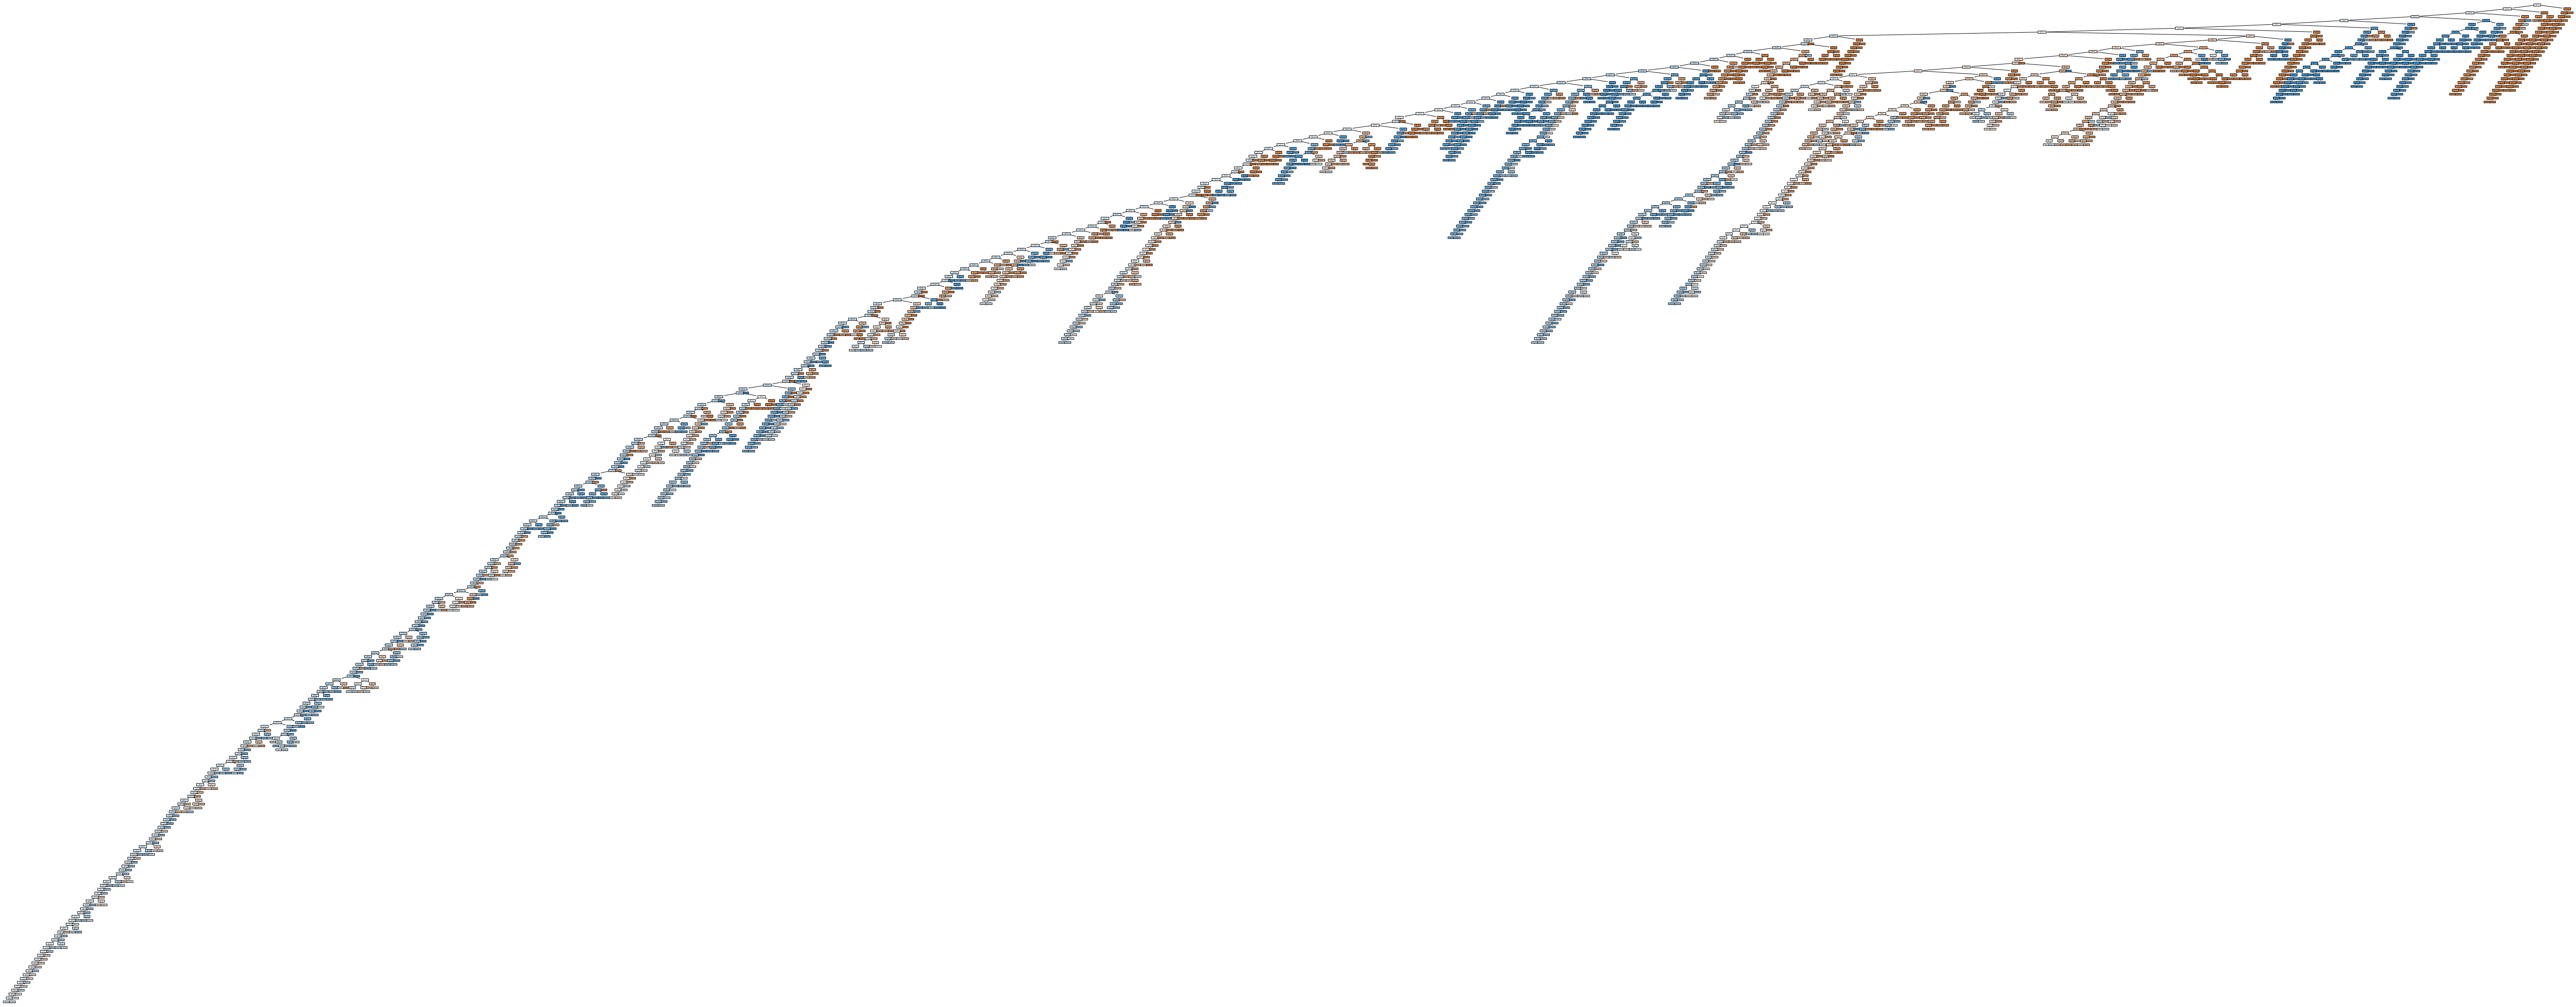

In [97]:
plt.figure(figsize=(100,40))
plot_tree(dt, filled=True, rounded=True, impurity=True, feature_names=features)

In [98]:
from sklearn.tree import _tree
def get_rules(tree, feature_names, class_names):
    tree_ = tree.tree_
    feature_name = [
        feature_names[i] if i != _tree.TREE_UNDEFINED else "undefined!"
        for i in tree_.feature
    ]

    paths = []
    path = []
    
    def recurse(node, path, paths):
        
        if tree_.feature[node] != _tree.TREE_UNDEFINED:
            name = feature_name[node]
            threshold = tree_.threshold[node]
            p1, p2 = list(path), list(path)
            p1 += [f"({name} <= {np.round(threshold, 3)})"]
            recurse(tree_.children_left[node], p1, paths)
            p2 += [f"({name} > {np.round(threshold, 3)})"]
            recurse(tree_.children_right[node], p2, paths)
        else:
            path += [(tree_.value[node], tree_.n_node_samples[node])]
            paths += [path]
            
    recurse(0, path, paths)

    # sort by samples count
    samples_count = [p[-1][1] for p in paths]
    ii = list(np.argsort(samples_count))
    paths = [paths[i] for i in reversed(ii)]
    
    rules = []
    for path in paths:
        rule = "if "
        
        for p in path[:-1]:
            if rule != "if ":
                rule += " and "
            rule += str(p)
        rule += " then "
        if class_names is None:
            rule += "response: "+str(np.round(path[-1][0][0][0],3))
        else:
            classes = path[-1][0][0]
            l = np.argmax(classes)
            rule += f"class: {class_names[l]} (proba: {np.round(100.0*classes[l]/np.sum(classes),2)}%)"
        rule += f" | based on {path[-1][1]:,} samples"
        rules += [rule]
        
    return rules

In [99]:
rules = get_rules(dt, features, denial_codes)#list(["True", "False"]))
for r in rules:
    print(r)

if (99213 <= 0.5) and (SDX-Z99.2 <= 0.5) and (85025 <= 0.5) and (84550 <= 0.5) and (83735 <= 0.5) and (82607 <= 0.5) and (99203 <= 0.5) and (SDX-E55.9 <= 0.5) and (99214 <= 0.5) and (99204 <= 0.5) and (97140 <= 0.5) and (RFV-N76.0 <= 0.5) and (97110 <= 0.5) and (97014 <= 0.5) and (81001 <= 0.5) and (97010 <= 0.5) and (84100 <= 0.5) and (82728 <= 0.5) and (83540 <= 0.5) and (83615 <= 0.5) and (SDX-Z01.812 <= 0.5) and (83036 <= 0.5) and (84630 <= 0.5) and (85610 <= 0.5) and (B78-4867-05174-01 <= 0.5) and (84439 <= 0.5) and (82310 <= 0.5) and (85730 <= 0.5) and (SDX-Z23 <= 0.5) and (99283 <= 0.5) and (SDX-K05.10 <= 0.5) and (84481 <= 0.5) and (RFV-R10.2 <= 0.5) and (82550 <= 0.5) and (PDX-K08.409 <= 0.5) and (80061 <= 0.5) and (85379 <= 0.5) and (PDX-K05.10 <= 0.5) and (O62-5653-04308-01 <= 0.5) and (99202 <= 0.5) and (99284 <= 0.5) and (B46-4387-00778-01 <= 0.5) and (93332 <= 0.5) and (86060 <= 0.5) and (83970 <= 0.5) and (83520 <= 0.5) and (PDX-K02.63 <= 0.5) and (C81-0459-03093-01 <= 0

if (99213 <= 0.5) and (SDX-Z99.2 <= 0.5) and (85025 <= 0.5) and (84550 <= 0.5) and (83735 <= 0.5) and (82607 <= 0.5) and (99203 <= 0.5) and (SDX-E55.9 <= 0.5) and (99214 <= 0.5) and (99204 <= 0.5) and (97140 <= 0.5) and (RFV-N76.0 > 0.5) and (87270 <= 0.5) and (87210 <= 0.5) and (87070 <= 0.5) and (87510 <= 0.5) and (87660 <= 0.5) and (87480 <= 0.5) and (87205 <= 0.5) and (81001 <= 0.5) and (RFV-R10.2 <= 0.5) and (87081 > 0.5) then class: PASS (proba: 100.0%) | based on 73 samples
if (99213 <= 0.5) and (SDX-Z99.2 <= 0.5) and (85025 <= 0.5) and (84550 <= 0.5) and (83735 <= 0.5) and (82607 <= 0.5) and (99203 <= 0.5) and (SDX-E55.9 > 0.5) and (84630 <= 0.5) and (82306 <= 0.5) and (SDX-E03.9 <= 0.5) and (84439 <= 0.5) and (82977 <= 0.5) and (81001 <= 0.5) and (99214 <= 0.5) and (PDX-D50.9 <= 0.5) and (SDX-Z23 <= 0.5) and (SDX-D50.9 <= 0.5) and (SDX-E78.5 <= 0.5) and (96372 <= 0.5) and (SDX-M79.2 <= 0.5) and (84443 <= 0.5) and (SDX-Z36.9 <= 0.5) and (P16-5946-05896-01 <= 0.5) and (82310 <= 